# Setup environment

In [14]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [2]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_torchFunctionILTERS = 64

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [4]:
# TODO: Load read and load the data here
df = pd.read_csv("twitter-suicidal-data.csv")
df

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
...,...,...
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1


## Data Preprocessing

In [5]:
import nltk
import emoji
import re

df = pd.read_csv("twitter-suicidal-data.csv")
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

In [2]:
def convert_emoji_to_text(text):
    text = emoji.replace_emoji(text, replace=' ')
    return text

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\d+', '', text)
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'@\w+', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = convert_emoji_to_text(text)
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in pos_tags]
    tokens = [token for token in tokens if token not in stopwords]

    return tokens

df['tokens'] = df['tweet'].apply(preprocess_data)
df['text_length'] = df['tweet'].apply(lambda x: len(x.split()))
df

,tweet,intention,tokens,text_length
0,my life is meaningless i just want to end my l...,1,"[life, meaningless, want, end, life, badly, li...",79
1,muttering i wanna die to myself daily for a fe...,1,"[mutter, wan, na, die, daily, month, feel, wor...",45
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif...",69
3,i did something on the 2 of october i overdose...,1,"[something, october, overdose, felt, alone, ho...",77
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, care, want, die, maybe, feel...",18
...,...,...,...,...
9114,have you ever laid on your bed at night and cr...,1,"[ever, lay, bed, night, cry, good, enough, cou...",33
9115,the fault the blame the pain s still there i m...,1,"[fault, blame, pain, still, alone, inside, bro...",20
9116,stop asking me to trust you when i m still cou...,1,"[stop, ask, trust, still, cough, water, last, ...",22
9117,i never know how to handle sadness crying make...,1,"[never, know, handle, sadness, cry, make, feel...",12


In [7]:
print(preprocess_data("my life is meaningless i ,,,...just want ;;to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives"))

['life', 'meaningless', 'want', 'end', 'life', 'badly', 'life', 'completely', 'empty', 'dont', 'want', 'create', 'meaning', 'create', 'meaning', 'pain', 'long', 'hold', 'back', 'urge', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposite', 'way', 'stop', 'feel', 'jealous', 'tragic', 'character', 'like', 'gomer', 'pile', 'swift', 'end', 'able', 'bring', 'life']


# Word2Vec - Word Embedding

In [7]:
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [3]:
W2V_PATH = "GoogleNews-vectors-negative300.bin"

if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    try:
        w2v_model = keyedvectors.load_word2vec_format(W2V_PATH, binary=True)
        print("Word2Vec model is loaded.")
    except Exception as e:
        print(f"Error loading the model: {e}")
else:
    print("Downloading Word2Vec model...")
    from gensim import downloader as api
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2Vec model is downloaded.")
    if W2V_PATH is not None:
        print("\nSaving Word2Vec model...")
        w2v_model.save_word2vec_format(W2V_PATH, binary=True)
        print("Word2Vec model is saved.")


fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis
Loading Word2Vec model...
Word2Vec model is loaded.
Embedding vector dimension: 300


In [10]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size
print(f"Embedding vector dimension: {EMBEDDING_VECTOR_DIM}")

Embedding vector dimension: 300


# Dataset

In [4]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"
        self._proc_dataset()
        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vectors = []
        for token in tokens:
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append(np.zeros(self.vector_size, dtype=np.float32))
        padded_vectors = self._pad(vectors)
        return torch.tensor(padded_vectors, dtype=torch.float32)

    def _pad(self, tokens: list):
        if len(tokens) < self.max_sequence_len:
            tokens.extend([''] * (self.max_sequence_len - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)
  

Deleted 0-Len Samples: 23


/tmp/ipykernel_7636/2006730870.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
/tmp/ipykernel_7636/2006730870.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(padded_vectors, dtype=torch.float32)
/tmp/ipykernel_7636/2006730870.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

Train dataset length: 7272
Deleted 0-Len Samples: 8


/tmp/ipykernel_7636/2006730870.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Valid dataset length: 1816


/tmp/ipykernel_7636/2006730870.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


# Prepare Data

## Split Data into train-valid

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Create Datasets

In [13]:
# create twitter dataset
train_dataset = Twitter(
    train_df, w2v_model, sequence_len
)

print(f"Train dataset length: {len(train_dataset)}")

valid_dataset = Twitter(
    test_df, w2v_model, sequence_len
)
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 23


/tmp/ipykernel_139383/4060927618.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
/tmp/ipykernel_139383/4060927618.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(padded_vectors, dtype=torch.float32)
/tmp/ipykernel_139383/4060927618.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Train dataset length: 7272
Deleted 0-Len Samples: 8


/tmp/ipykernel_139383/4060927618.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


In [21]:
valid_dataset = Twitter(
    test_df, w2v_model, sequence_len
)
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 8


/tmp/ipykernel_8522/1007179429.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Valid dataset length: 1816


/tmp/ipykernel_8522/1007179429.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


# Model and Train

## Utils

In [5]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total_correct = 0
    total_samples = 0

    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round((correct / total_samples) * 100, 5),
        )

    test_loss /= total_samples
    test_acc = (correct / total_samples) * 100

    return test_loss, test_acc

In [6]:
from typing import Union

def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: Union[str, 'cuda', 'cpu', 'auto'] = 'auto',
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        total_correct = 0
        total_samples = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=False)
        for idx, (inputs, labels) in enumerate(itr, start=1):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_function(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            
            total_correct += correct
            total_samples += labels.size(0)
            epoch_acc = total_correct / total_samples

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
            )

        train_losses.append(epoch_loss / total_samples)
        train_accs.append(epoch_acc)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,
      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [7]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [8]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    ############################################################
    all_labels = []
    all_predictions = []    

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().tolist())
        all_predictions.extend(predicted.cpu().tolist())

    labels = all_labels
    predicted = all_predictions
    ############################################################
    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [20]:
import torch.nn.functional as torchFunction

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1Neuron1 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.layer1Neuron2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.layer1Neuron3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7)

        self.layer2Neuron1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.layer2Neuron2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5)
        self.layer2Neuron3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        
        conv_output_size = self._get_conv_output_size()

        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torchFunction.relu(self.layer1Neuron1(x))
        x = torchFunction.relu(self.layer1Neuron2(x))
        x = torchFunction.relu(self.layer1Neuron3(x))

        x = torchFunction.relu(self.layer2Neuron1(x))
        x = torchFunction.relu(self.layer2Neuron2(x))
        x = torchFunction.relu(self.layer2Neuron3(x))
        
        x = self.pool2(x)

        x = self.flatten(x)
        
        x = torchFunction.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _get_conv_output_size(self):
        x = torch.randn(1, 64, 300) 
        x = torchFunction.relu(self.layer1Neuron1(x))
        x = torchFunction.relu(self.layer1Neuron2(x))
        x = torchFunction.relu(self.layer1Neuron3(x))
        x = torchFunction.relu(self.layer2Neuron1(x))
        x = torchFunction.relu(self.layer2Neuron2(x))
        x = torchFunction.relu(self.layer2Neuron3(x))
        x = self.pool2(x)
        x = self.flatten(x)
        return x.shape[1]

class Batch_normalizes_cnn(nn.Module):
    def __init__(self):
        super(Batch_normalizes_cnn, self).__init__()
        
        self.layer1Neuron1 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchNorm11 = nn.BatchNorm1d(64)
        
        self.layer1Neuron2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchNorm12 = nn.BatchNorm1d(64)
        
        self.layer1Neuron3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchNorm13 = nn.BatchNorm1d(64)

        self.layer2Neuron1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchNorm21 = nn.BatchNorm1d(128)
        
        self.layer2Neuron2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchNorm22 = nn.BatchNorm1d(128)
        
        self.layer2Neuron3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchNorm23 = nn.BatchNorm1d(128)
        
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        conv_output_size = self._get_conv_output_size()

        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torchFunction.relu(self.batchNorm11(self.layer1Neuron1(x)))
        x = torchFunction.relu(self.batchNorm12(self.layer1Neuron2(x)))
        x = torchFunction.relu(self.batchNorm13(self.layer1Neuron3(x)))

        x = torchFunction.relu(self.batchNorm21(self.layer2Neuron1(x)))
        x = torchFunction.relu(self.batchNorm22(self.layer2Neuron2(x)))
        x = torchFunction.relu(self.batchNorm23(self.layer2Neuron3(x)))
        
        x = self.pool2(x)

        x = self.flatten(x)
        x = torchFunction.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _get_conv_output_size(self):
        x = torch.randn(1, 64, 300)
        x = torchFunction.relu(self.batchNorm11(self.layer1Neuron1(x)))
        x = torchFunction.relu(self.batchNorm12(self.layer1Neuron2(x)))
        x = torchFunction.relu(self.batchNorm13(self.layer1Neuron3(x)))
        x = torchFunction.relu(self.batchNorm21(self.layer2Neuron1(x)))
        x = torchFunction.relu(self.batchNorm22(self.layer2Neuron2(x)))
        x = torchFunction.relu(self.batchNorm23(self.layer2Neuron3(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        return x.shape[1]



## Training

In [21]:
model = Batch_normalizes_cnn()

In [22]:
batch_size = BATCH_SIZE
epochs = EPOCHS
device = DEVICE
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

cnn_model_train_history = train_model(
    model=model,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=epochs,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=device
)

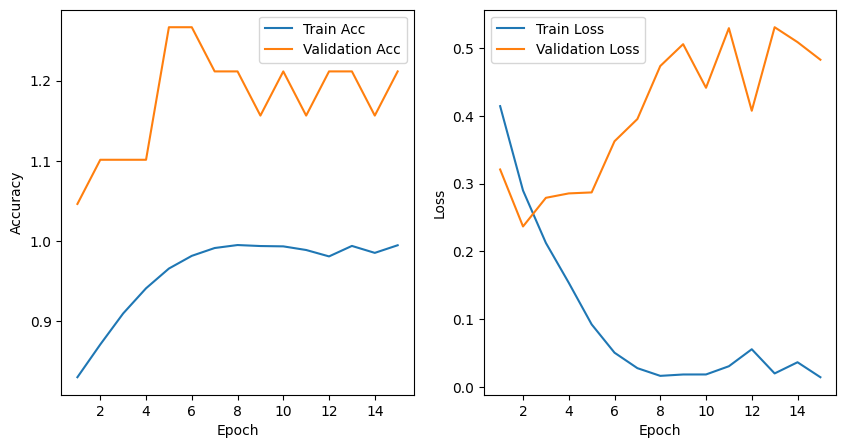

In [23]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

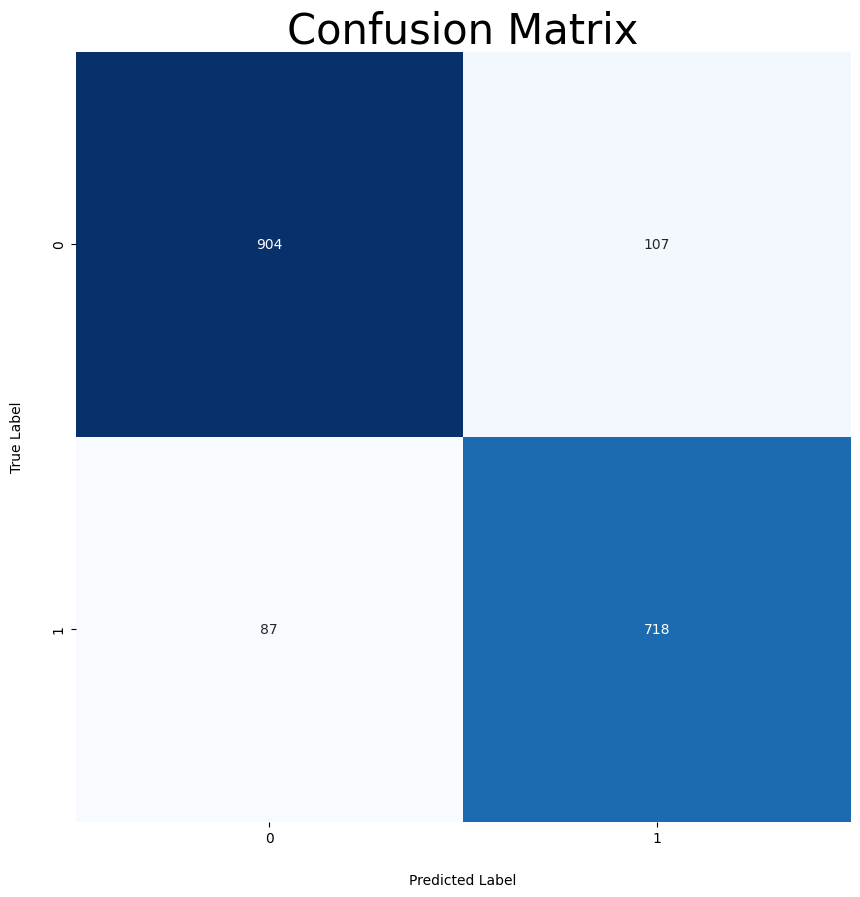

In [24]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [25]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.893
F1:        0.892
Precision: 0.891
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1011
           1       0.87      0.89      0.88       805

    accuracy                           0.89      1816
   macro avg       0.89      0.89      0.89      1816
weighted avg       0.89      0.89      0.89      1816



3. Tuning the Size of the CNN Model's Context Window

In [29]:
import torch.nn.functional as torchFunction
import torch
import torch.nn as nn
#dropout regularization
class Dropout_cnn(nn.Module):
    def __init__(self):
        super(Dropout_cnn, self).__init__()
        
        self.layer1Neuron1 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.dropout11 = nn.Dropout(0.5)
        self.layer1Neuron2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.dropout12 = nn.Dropout(0.5)
        self.layer1Neuron3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7)
        self.dropout13 = nn.Dropout(0.5)

        self.layer2Neuron1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.dropout21 = nn.Dropout(0.5)
        self.layer2Neuron2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5)
        self.dropout22 = nn.Dropout(0.5)
        self.layer2Neuron3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        self.dropout23 = nn.Dropout(0.5)
        
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        
        conv_output_size = self._get_conv_output_size()

        self.fc1 = nn.Linear(conv_output_size, 128)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torchFunction.relu(self.layer1Neuron1(x))
        x = self.dropout11(x)
        x = torchFunction.relu(self.layer1Neuron2(x))
        x = self.dropout12(x)
        x = torchFunction.relu(self.layer1Neuron3(x))
        x = self.dropout13(x)

        x = torchFunction.relu(self.layer2Neuron1(x))
        x = self.dropout21(x)
        x = torchFunction.relu(self.layer2Neuron2(x))
        x = self.dropout22(x)
        x = torchFunction.relu(self.layer2Neuron3(x))
        x = self.dropout23(x)
        
        x = self.pool2(x)

        x = self.flatten(x)
        
        x = torchFunction.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = self.fc2(x)

        return x

    def _get_conv_output_size(self):
        x = torch.randn(1, 64, 300)
        x = torchFunction.relu(self.layer1Neuron1(x))
        x = self.dropout11(x)
        x = torchFunction.relu(self.layer1Neuron2(x))
        x = self.dropout12(x)
        x = torchFunction.relu(self.layer1Neuron3(x))
        x = self.dropout13(x)
        x = torchFunction.relu(self.layer2Neuron1(x))
        x = self.dropout21(x)
        x = torchFunction.relu(self.layer2Neuron2(x))
        x = self.dropout22(x)
        x = torchFunction.relu(self.layer2Neuron3(x))
        x = self.dropout23(x)
        x = self.pool2(x)
        x = self.flatten(x)
        return x.shape[1]

model = Dropout_cnn()
batch_size = BATCH_SIZE
epochs = EPOCHS
device = DEVICE
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

cnn_model_train_history = train_model(
    model=model,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=epochs,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=device
)


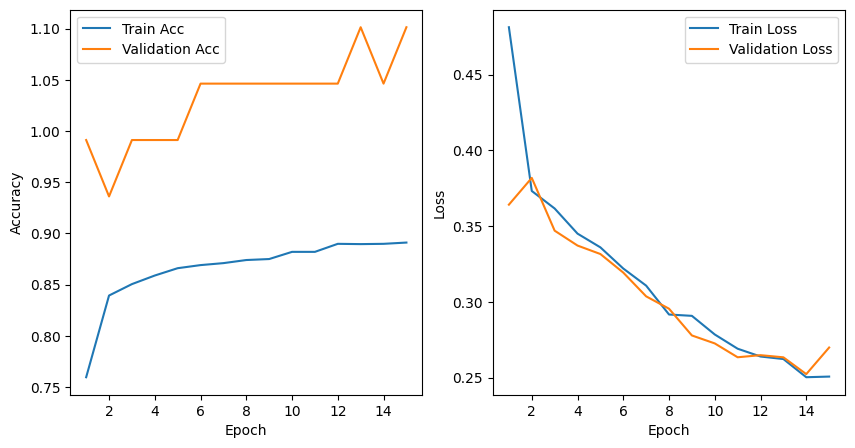

In [30]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

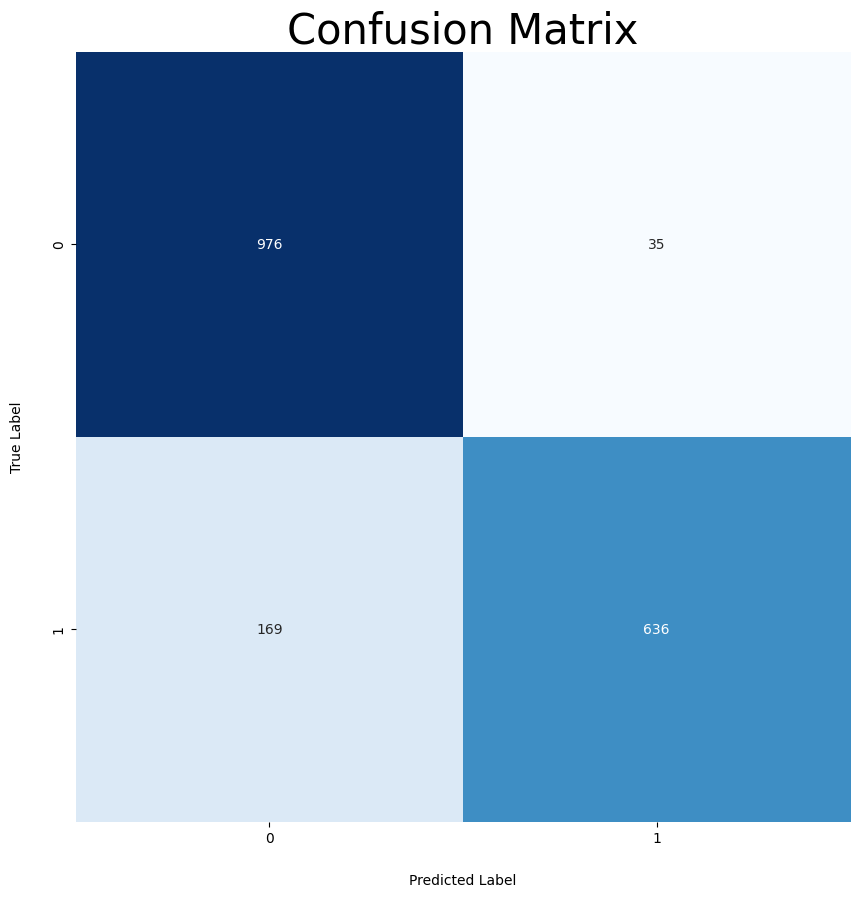

In [31]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [32]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.878
F1:        0.884
Precision: 0.900
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1011
           1       0.95      0.79      0.86       805

    accuracy                           0.89      1816
   macro avg       0.90      0.88      0.88      1816
weighted avg       0.89      0.89      0.89      1816



In [36]:
class Seq_len_cnn(nn.Module):
    def __init__(self):
        super(Seq_len_cnn, self).__init__()
        
        self.layer1Neuron1 = nn.Conv1d(in_channels=64, out_channels=196, kernel_size=3, stride=1, padding=1)
        self.batchNorm11 = nn.BatchNorm1d(64)
        
        self.layer1Neuron2 = nn.Conv1d(in_channels=64, out_channels=61964, kernel_size=3, stride=1, padding=1)
        self.batchNorm12 = nn.BatchNorm1d(64)
        
        self.layer1Neuron3 = nn.Conv1d(in_channels=64, out_channels=196, kernel_size=3, stride=1, padding=1)
        self.batchNorm13 = nn.BatchNorm1d(64)

        self.layer2Neuron1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchNorm21 = nn.BatchNorm1d(128)
        
        self.layer2Neuron2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchNorm22 = nn.BatchNorm1d(128)
        
        self.layer2Neuron3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchNorm23 = nn.BatchNorm1d(128)
        
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        conv_output_size = self._get_conv_output_size()

        self.fc1 = nn.Linear(conv_output_size, 196)
        self.fc2 = nn.Linear(196, 2)

    def forward(self, x):
        x = torchFunction.relu(self.batchNorm11(self.layer1Neuron1(x)))
        x = torchFunction.relu(self.batchNorm12(self.layer1Neuron2(x)))
        x = torchFunction.relu(self.batchNorm13(self.layer1Neuron3(x)))

        x = torchFunction.relu(self.batchNorm21(self.layer2Neuron1(x)))
        x = torchFunction.relu(self.batchNorm22(self.layer2Neuron2(x)))
        x = torchFunction.relu(self.batchNorm23(self.layer2Neuron3(x)))
        
        x = self.pool2(x)

        x = self.flatten(x)
        
        x = torchFunction.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _get_conv_output_size(self):
        x = torch.randn(1, 64, 196)
        x = torchFunction.relu(self.batchNorm11(self.layer1Neuron1(x)))
        x = torchFunction.relu(self.batchNorm12(self.layer1Neuron2(x)))
        x = torchFunction.relu(self.batchNorm13(self.layer1Neuron3(x)))
        x = torchFunction.relu(self.batchNorm21(self.layer2Neuron1(x)))
        x = torchFunction.relu(self.batchNorm22(self.layer2Neuron2(x)))
        x = torchFunction.relu(self.batchNorm23(self.layer2Neuron3(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        return x.shape[1]


In [39]:
SEQUENCE_LEN = 196
model = Seq_len_cnn()
batch_size = BATCH_SIZE * 3
epochs = EPOCHS
device = DEVICE
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=(LEARNING_RATE / 100))

cnn_model_train_history = train_model(
    model=model,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=epochs,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=device
)

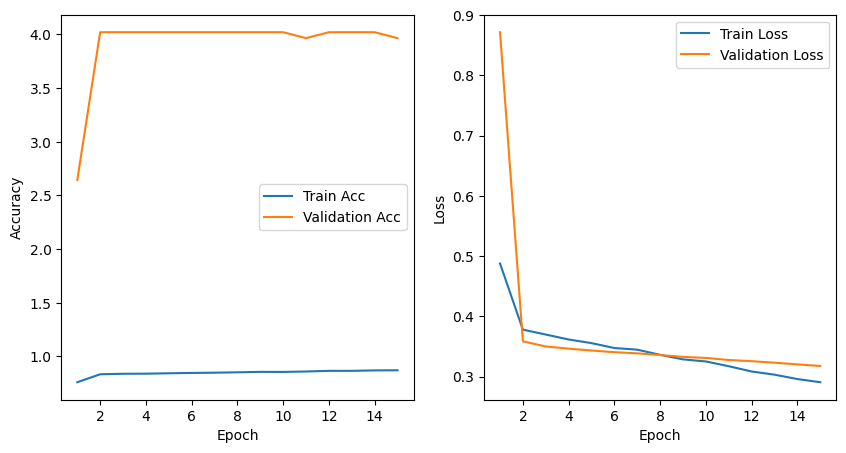

In [40]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

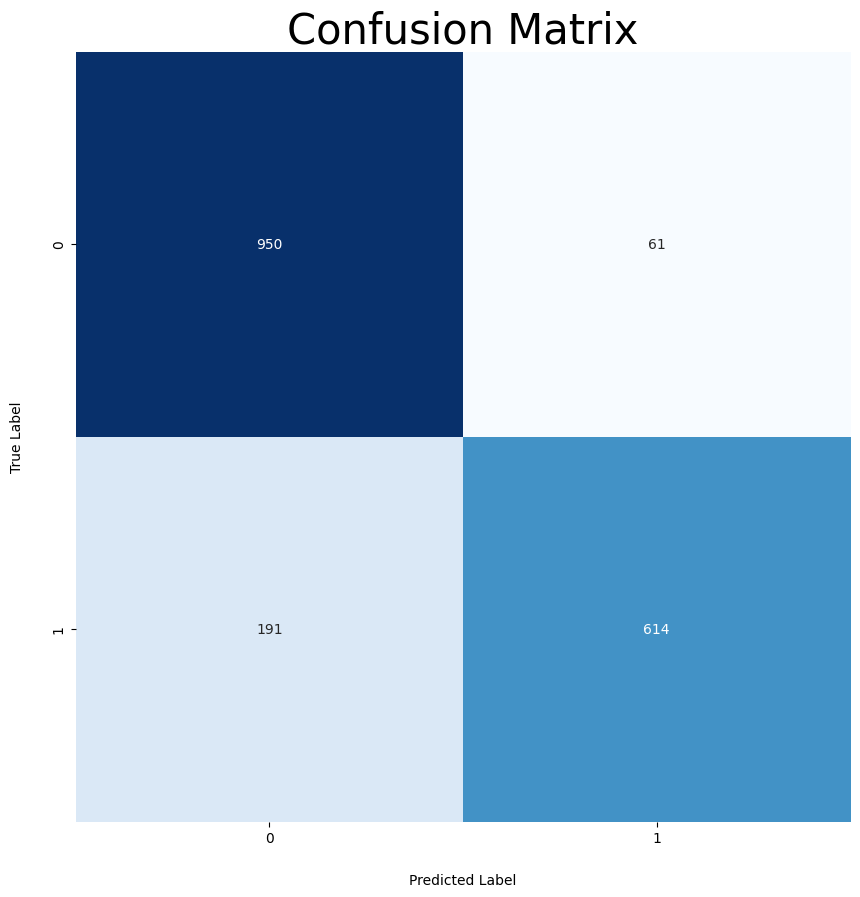

In [41]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [42]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.851
F1:        0.856
Precision: 0.871
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1011
           1       0.91      0.76      0.83       805

    accuracy                           0.86      1816
   macro avg       0.87      0.85      0.86      1816
weighted avg       0.87      0.86      0.86      1816

